In [1]:
import sys,json
import powerlaw
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
N = 10000
m = 5
A = 0
_seed = 12345

In [3]:
def py_random_state(random_state_index):
    return nx.utils.py_random_state(random_state_index)

def _random_subset(seq, m, rng):
    """ Return m unique elements from seq.
    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.
    Note: rng is a random.Random or numpy.random.RandomState instance.
    """
    targets = set()
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets

@py_random_state(3)
def barabasi_albert_attractiveness(n, m, a, seed=None):
    if m < 1 or m >= n:
        raise nx.NetworkXError("Barabasi-Albert network must have m >= 1"
                               " and m < n, m = %d, n = %d" % (m, n))

    G = nx.empty_graph(m)
    # Target nodes for new edges
    targets = list(range(m))
    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = targets * a
    # Start adding the other n-m nodes. The first node is m.
    source = m
    while source < n:
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * (m+a))
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = _random_subset(repeated_nodes, m, seed)
        source += 1
    return G

In [4]:
g = barabasi_albert_attractiveness(N, m, A, _seed)

Calculating best minimal value for power law fit
/Users/murase/.local/share/virtualenvs/sim_BA_model-Z_q-zmdG/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/murase/.local/share/virtualenvs/sim_BA_model-Z_q-zmdG/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


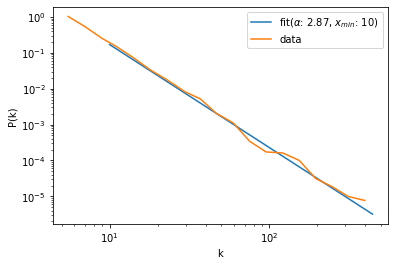

In [5]:
ks = [x[1] for x in g.degree()]
results = powerlaw.Fit(ks, discrete=True)

figPDF = results.power_law.plot_pdf(label=r"fit($\alpha$: %.2f, $x_{min}$: %d)" % (results.alpha, results.xmin)) 
figPDF.set_ylabel("P(k)")
figPDF.set_xlabel("k")
cdf = {z[0]:z[1] for z in zip(*powerlaw.cdf(ks))}
cdf_xmin = cdf[results.xmin]

bin_edges, prob = powerlaw.pdf(ks)
x = [ (bin_edges[i]+bin_edges[i+1])/2.0 for i in range(0, len(bin_edges)-1) ]
plt.plot(x, prob/(1.0-cdf_xmin), label="data")
plt.legend()

plt.savefig('pk.png')

In [6]:
with open('_output.json', 'w') as f:
    json.dump({"alpha": results.power_law.alpha, "x_min": results.power_law.xmin}, f)